<a href="https://colab.research.google.com/github/baicheto/AML_Bitcoin/blob/Kri/AML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Anti-Money Launderig - Elliptic dataset**
- The dataset is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.
- The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.



In [ ]:
!pip install --quiet --upgrade pip setuptools
!pip install --quiet torch_geometric gensim matplotlib seaborn networkx python-louvain scikit-learn scipy

In [ ]:
# First, uninstall existing versions to avoid conflicts
!pip uninstall -y torch torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib torch-geometric

# Install PyTorch 2.0.0 with CUDA 11.7
!pip install --quiet torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

# Install PyTorch Geometric dependencies with prebuilt wheels
!pip install --quiet torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu117.html


**After running the cells above, manually Restart Runtime**

### Imports

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/AML/elliptic_bitcoin_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import random, multiprocessing as mp, itertools, json, os
import gensim
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch_geometric
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

Torch version: 2.0.0+cu117
Torch Geometric version: 2.6.1


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)

In [ ]:
from itertools import product

In [ ]:
import random
import multiprocessing as mp
from itertools import product
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.optim as optim

from gensim.models import Word2Vec
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
import os
from google.colab import files

### 0. Read the files

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
edges = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
classes = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')

In [ ]:
trans_features = [f"trans_feat_{i}" for i in range(2, 95)]
agg_features   = [f"agg_feat_{i}"   for i in range(1, 73)]
features.columns = ["txId", "time_step"] + trans_features + agg_features

In [ ]:
features_local = features[ ["txId","time_step"] + trans_features ]
features_agg   = features[ ["txId"] + agg_features ]

In [ ]:
print(f"""Shapes
    Features : {features.shape[0]:,} rows  ×  {features.shape[1]} cols
    Classes  : {classes.shape[0]:,} rows  ×  {classes.shape[1]} cols
    Edgelist : {edges.shape[0]:,} rows  ×  {edges.shape[1]} cols
""")

Shapes
    Features : 203,769 rows  ×  167 cols
    Classes  : 203,769 rows  ×  2 cols
    Edgelist : 234,355 rows  ×  2 cols



In [ ]:
features.head()

,txId,time_step,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [ ]:
features_local.head()

,txId,time_step,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,trans_feat_85,trans_feat_86,trans_feat_87,trans_feat_88,trans_feat_89,trans_feat_90,trans_feat_91,trans_feat_92,trans_feat_93,trans_feat_94
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.255111,-0.259194,1.125590,1.128038,-0.293773,-0.159732,0.034039,-0.183816,1.135523,1.135279
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.255168,-0.259251,-0.187191,-0.185274,-0.293692,-0.760700,-0.692777,-0.719789,-1.084907,-1.084845
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.254373,-0.258387,-1.499972,-1.498585,-0.021809,1.936814,2.448785,1.775108,-1.084907,-1.084845
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.255168,0.717108,-0.187191,-0.185274,3.991587,0.810879,-0.694235,2.084651,0.025308,0.025217
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.255162,-0.259249,-0.696206,-0.714093,-0.293897,-0.761399,-0.693922,-0.720790,-0.487315,-0.563089


In [ ]:
edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [ ]:
classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


Map the illicit and licit transactions to 1 and 2 respectively

In [ ]:
# Map classes to labels: illicit=1, licit=0, unknown=-1
classes['class'] = (
    classes['class'].astype(str)
    .str.strip()
    .map({'1': 'illicit', '2': 'licit'})
    .fillna('unknown')
)
label_map = {'illicit': 1, 'licit': 0, 'unknown': -1}
classes['label'] = classes['class'].map(label_map)

In [ ]:
percentage_distribution = round(100 * classes['class'].value_counts(normalize=True), 2)
class_counts = classes['class'].value_counts()

In [ ]:
classes.head()

,txId,class,label
0,230425980,unknown,-1
1,5530458,unknown,-1
2,232022460,unknown,-1
3,232438397,licit,0
4,230460314,unknown,-1


In [ ]:
print(classes['class'].value_counts())
print(classes['label'].value_counts())

class
unknown    157205
licit       42019
illicit      4545
Name: count, dtype: int64
label
-1    157205
 0     42019
 1      4545
Name: count, dtype: int64


In [ ]:
classes_df = classes[['txId', 'class']].copy()
classes_df['Percentage'] = classes_df['class'].map(percentage_distribution)
classes_df['Counts'] = classes_df['class'].map(class_counts)

In [ ]:
classes_df.head()

,txId,class,Percentage,Counts
0,230425980,unknown,77.15,157205
1,5530458,unknown,77.15,157205
2,232022460,unknown,77.15,157205
3,232438397,licit,20.62,42019
4,230460314,unknown,77.15,157205


### 1. Building the Full Transaction Graph G

**EDA**

Let's create a NetworkX graph G from the edge list, where:

Each node is a Bitcoin transaction (txId1, txId2).

Each edge represents a transaction flow between two transactions (a directed connection in practice)

In [ ]:
G = nx.from_pandas_edgelist(edges, 'txId1', 'txId2')

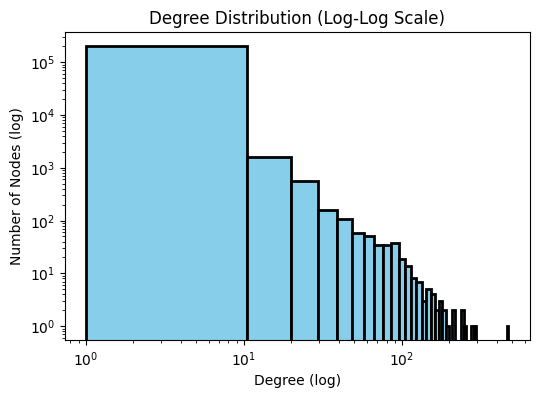

In [ ]:
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2)
plt.xscale('log'); plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)'); plt.ylabel('Number of Nodes (log)')
plt.show()

This graph shows that the network has a heavy-tailed degree distribution.

A few transactions interact with many others — potential hubs.

Most transactions interact with very few others.

The results are pretty common for financial-transaction graphs

In [ ]:
print(f"Connected components: {nx.number_connected_components(G)}")
giant = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant).copy()
print(f"Giant component nodes: {G_giant.number_of_nodes():,}; edges: {G_giant.number_of_edges():,}")

Connected components: 49
Giant component nodes: 7,880; edges: 9,164


### 2. Building 2-hop Subgraph

In [ ]:
# 2a) collect all labeled txIds (labels ≥ 0 include unknown=-1? no, unknown=-1 excluded)
labeled = set(classes.loc[classes['label'] >= 0, 'txId'])

In [ ]:
# 2b) 2-hop neighborhood around each labeled node
sub_nodes = set()
for tx in labeled:
    if tx in G:
        sub_nodes |= set(nx.single_source_shortest_path_length(G, tx, cutoff=2).keys())

G_sub = G.subgraph(sub_nodes).copy()

In [ ]:
# 2c) map subgraph node ids to integers
all_nodes_sub = sorted(G_sub.nodes())
tx_idx_sub    = {tx: i for i, tx in enumerate(all_nodes_sub)}

def nx_from_edgelist(df_edges, mapping):
    df_int = df_edges[['txId1','txId2']].copy()
    df_int['txId1'] = df_int['txId1'].map(mapping)
    df_int['txId2'] = df_int['txId2'].map(mapping)
    df_int = df_int.dropna().astype(int)
    return nx.from_pandas_edgelist(df_int, 'txId1', 'txId2')

G_int_sub = nx_from_edgelist(edges, tx_idx_sub)

In [ ]:
# build the set of all unknown txIds
unknown_tx = set(classes.loc[classes['label'] == -1, 'txId'])
unknown_in_sub = sub_nodes & unknown_tx

print(f"Total 2-hop nodes:          {len(sub_nodes)}")
print(f"Unknown nodes in subgraph:  {len(unknown_in_sub)}")
print(f"Fraction unknown: {len(unknown_in_sub)/len(sub_nodes):.2%}")

Total 2-hop nodes:          133858
Unknown nodes in subgraph:  87294
Fraction unknown: 65.21%


### 3. Prepare Labels, Time-steps, Intrinsic Features

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 3a) labels aligned to all_nodes_sub
y_series = classes.set_index('txId')['label']
y = torch.tensor(y_series.reindex(all_nodes_sub).values, dtype=torch.long)
labels   = y.to(device)

In [ ]:
# 3b) time steps aligned
time_steps = (
    features_local.set_index('txId')
    .loc[all_nodes_sub, 'time_step']
    .values
)
ts_tensor = torch.tensor(time_steps, device=device)

In [ ]:
# 3c) intrinsic feature tensor
feat_intr_arr = (
    features_local.set_index('txId')
    .loc[all_nodes_sub, trans_features]
    .values
)
feat_intr = torch.tensor(feat_intr_arr, dtype=torch.float, device=device)

### 4.1. Centralities

In [ ]:
CENT_FILES = {
    'degree'     : 'degree_centrality.pkl',
    'betweenness': 'betweenness_centrality.pkl',
    'closeness'  : 'closeness_centrality.pkl',
    'eigenvector': 'eigen_centrality.pkl',
}

centralities = {}

In [ ]:
# 4a) Degree centrality
fname = CENT_FILES['degree']
if os.path.exists(fname):
    with open(fname, 'rb') as f:
        deg = pickle.load(f)
else:
    # 1) compute on G_int_sub
    deg = nx.degree_centrality(G_int_sub)

    # 2) save the raw pickle
    with open(fname, 'wb') as f:
        pickle.dump(deg, f)
    print(f"✅  Saved PKL {fname}")

# — now INVERT the mapping from integer IDs back to txId:
inv_map = { i: tx for tx, i in tx_idx_sub.items() }

# 3) build a pandas Series indexed by the ORIGINAL txId
ser_deg = pd.Series(
    { inv_map[i]: deg[i] for i in deg },
    name='degree'
)

# 4) reindex to all_nodes_sub to get a full N_sub × 1 table
df_deg = ser_deg.reindex(all_nodes_sub).fillna(0).to_frame()
df_deg.index.name = 'txId'

# 5) save & download the CSV
csv_file = 'degree_centrality.csv'
df_deg.to_csv(csv_file)
print(f"✅  Saved CSV {csv_file}")
files.download(csv_file)

# 6) stash it into your centralities dict for the tensor build
centralities['degree'] = df_deg['degree'].to_dict()

In [ ]:
# 4b) Betweenness centrality
fname = CENT_FILES['betweenness']
if os.path.exists(fname):
    with open(fname, 'rb') as f:
        btw = pickle.load(f)
else:
    # 1) compute on G_int_sub
    btw = nx.betweenness_centrality(G_int_sub)

    # 2) save the raw pickle
    with open(fname, 'wb') as f:
        pickle.dump(btw, f)
    print(f"✅  Saved PKL {fname}")

# — now INVERT the mapping from integer IDs back to txId:
inv_map = { i: tx for tx, i in tx_idx_sub.items() }

# 3) build a pandas Series indexed by the ORIGINAL txId
ser_btw = pd.Series(
    { inv_map[i]: btw[i] for i in btw },
    name='betweenness'
)

# 4) reindex to all_nodes_sub to get a full N_sub × 1 table
df_btw = ser_btw.reindex(all_nodes_sub).fillna(0).to_frame()
df_btw.index.name = 'txId'

# 5) save & download the CSV
csv_file = 'betweenness_centrality.csv'
df_btw.to_csv(csv_file)
print(f"✅  Saved CSV {csv_file}")
files.download(csv_file)

# 6) stash it into your centralities dict for the tensor build
centralities['betweenness'] = df_btw['betweenness'].to_dict()

In [ ]:
# 4c) Closeness centrality
fname = CENT_FILES['closeness']
if os.path.exists(fname):
    with open(fname, 'rb') as f:
        clo = pickle.load(f)
else:
    # 1) compute on G_int_sub
    clo = nx.closeness_centrality(G_int_sub)

    # 2) save the raw pickle
    with open(fname, 'wb') as f:
        pickle.dump(clo, f)
    print(f"✅  Saved PKL {fname}")

# — now INVERT the mapping from integer IDs back to txId:
inv_map = { i: tx for tx, i in tx_idx_sub.items() }

# 3) build a pandas Series indexed by the ORIGINAL txId
ser_clo = pd.Series(
    { inv_map[i]: clo[i] for i in clo },
    name='closeness'
)

# 4) reindex to all_nodes_sub to get a full N_sub × 1 table
df_clo = ser_clo.reindex(all_nodes_sub).fillna(0).to_frame()
df_clo.index.name = 'txId'

# 5) save & download the CSV
csv_file = 'closeness_centrality.csv'
df_clo.to_csv(csv_file)
print(f"✅  Saved CSV {csv_file}")
files.download(csv_file)

# 6) stash it into your centralities dict for the tensor build
centralities['closeness'] = df_clo['closeness'].to_dict()

In [ ]:
# 4d) Eigenvector centrality
fname = CENT_FILES['eigenvector']
if os.path.exists(fname):
    with open(fname, 'rb') as f:
        deg = pickle.load(f)
else:
    # 1) compute on G_int_sub
    eig = nx.eigenvector_centrality(G_int_sub)

    # 2) save the raw pickle
    with open(fname, 'wb') as f:
        pickle.dump(eig, f)
    print(f"✅  Saved PKL {fname}")

# — now INVERT the mapping from integer IDs back to txId:
inv_map = { i: tx for tx, i in tx_idx_sub.items() }

# 3) build a pandas Series indexed by the ORIGINAL txId
ser_eig = pd.Series(
    { inv_map[i]: eig[i] for i in eig },
    name='eigenvector'
)

# 4) reindex to all_nodes_sub to get a full N_sub × 1 table
df_eig = ser_eig.reindex(all_nodes_sub).fillna(0).to_frame()
df_eig.index.name = 'txId'

# 5) save & download the CSV
csv_file = 'eigenvector_centrality.csv'
df_eig.to_csv(csv_file)
print(f"✅  Saved CSV {csv_file}")
files.download(csv_file)

# 6) stash it into your centralities dict for the tensor build
centralities['eigenvector'] = df_eig['eigenvector'].to_dict()

### 4.2.  Manual Features

In [40]:
# 4e.1) Load each centrality dict from its pickle
with open('degree_centrality.pkl','rb')      as f: degree     = pickle.load(f)
with open('betweenness_centrality.pkl','rb') as f: betweenness= pickle.load(f)
with open('closeness_centrality.pkl','rb')   as f: closeness  = pickle.load(f)
with open('eigenvector_centrality.pkl','rb') as f: eigen      = pickle.load(f)

In [41]:
# 4e.2) Build DataFrame
df_cent = pd.DataFrame({
    'degree'     : pd.Series(degree),
    'betweenness': pd.Series(betweenness),
    'closeness'  : pd.Series(closeness),
    'eigenvector': pd.Series(eigen),
})
df_cent = df_cent.reindex(all_nodes_sub).fillna(0)
df_cent.index.name = 'txId'

In [43]:
# 4f) Convert to a tensor (shape: [N_sub, 4])
feat_cent = torch.tensor(df_cent.values, dtype=torch.float, device=device)

In [47]:
# 4g) final feature tensor = [intrinsic | manual centralities]
#    (shape: [N_sub, len(trans_features) + 4])
feat_tensor = torch.cat([feat_intr, feat_cent], dim=1)

In [48]:
N_sub = len(all_nodes_sub)
feat_tensor.shape == (N_sub, len(trans_features) + 4)

True

In [49]:
# 4h) build supervised splits, excluding unknowns (label == -1)
mask_known = labels >= 0
idx_known  = mask_known.nonzero(as_tuple=False).view(-1)
ts_known   = ts_tensor[mask_known]

train_idx = idx_known[ ts_known <= 30 ]
val_idx   = idx_known[(ts_known >= 31) & (ts_known <= 40)]
test_idx  = idx_known[ ts_known >= 41 ]

### 5. DeepWalk Machinery

In [50]:
def random_walk(graph, start, walk_length, rng=None):
    walk = [start]
    if rng is None:
        rng = random.Random()
    for _ in range(walk_length - 1):
        cur = walk[-1]
        nbrs = list(graph[cur])
        if not nbrs:
            break
        walk.append(rng.choice(nbrs))
    return walk

In [51]:
def _walk_worker(args):
    graph, batch, wl, wpn = args
    rng = random.Random()
    walks = []
    for n in batch:
        for _ in range(wpn):
            walks.append(random_walk(graph, n, wl, rng))
    return walks

In [52]:
def build_corpus(graph, walk_length=3, walks_per_node=2, workers=None):
    if workers is None:
        workers = mp.cpu_count()
    nodes   = list(graph.nodes())
    np.random.shuffle(nodes)
    batches = np.array_split(nodes, workers)
    with mp.Pool(workers) as pool:
        results = pool.map(
            _walk_worker,
            [(graph, b, walk_length, walks_per_node) for b in batches]
        )
    return [w for sub in results for w in sub]

In [53]:
def train_word2vec(
    sentences,
    dim=5,
    window=2,
    epochs=176,
    neg=1
):
    # single‐worker + fixed seed for determinism
    return Word2Vec(
        sentences=sentences,
        vector_size=dim,
        window=window,
        min_count=0,
        sg=1,
        hs=0,
        negative=neg,
        workers=1,
        epochs=epochs,
        seed=42
    )

In [54]:
def save_embeddings(w2v, path_pt='dwS.pt', path_txt='dwS.txt'):
    vecs = torch.tensor(w2v.wv.vectors)
    torch.save(vecs, path_pt)
    # (optional) text dump
    with open(path_txt, 'w') as f:
        N, D = vecs.shape
        f.write(f"{N} {D}\n")
        for node in w2v.wv.key_to_index:
            coords = " ".join(map(str, w2v.wv[node]))
            f.write(f"{node} {coords}\n")

In [55]:
def run_deepwalk(graph, out_pt='dwS.pt', out_txt='dwS.txt'):
    params = {
        'walk_length':  3,
        'walks_per_node': 2,
        'dim':          5,
        'window':       2,
        'neg':          1,
        'epochs':      176,
        'out_pt':      out_pt,
        'out_txt':     out_txt
    }
    corpus = build_corpus(
        graph,
        walk_length=params['walk_length'],
        walks_per_node=params['walks_per_node']
    )
    w2v = train_word2vec(
        corpus,
        dim=params['dim'],
        window=params['window'],
        epochs=params['epochs'],
        neg=params['neg']
    )
    save_embeddings(w2v, params['out_pt'], params['out_txt'])
    return params['out_pt']

### 6. Prepare training‐only subgraph, then full‐graph embeddings

In [56]:
# 6a) restrict to train+val nodes for initial embedding (optim tuning)
tv_nodes = torch.cat([train_idx, val_idx]).cpu().numpy().tolist()
G_tv     = G_int_sub.subgraph(tv_nodes).copy()

# generate embeddings on train+val subgraph (not used downstream directly)
_ = run_deepwalk(G_tv, out_pt='dwS_tv.pt', out_txt='ignore.txt')

In [57]:
# 6b) now generate final embeddings on the full subgraph (includes test)
emb_pt = run_deepwalk(G_int_sub, out_pt='dwS_full.pt', out_txt='ignore.txt')
Z_full = torch.load(emb_pt).to(device)   # shape (N_sub, 5)

### 7. Downstream “decoder” (2‐hidden‐layer NN)

In [58]:
# 8) Train decoder for exactly 80 epochs on train_idx, monitor on val_idx

In [59]:
class DeepWalkDecoder(nn.Module):
    def __init__(self, Z, feat, hidden=10):
        super().__init__()
        N, D = Z.shape
        F    = feat.size(1)
        self.emb  = nn.Embedding.from_pretrained(Z, freeze=False)
        self.fc1  = nn.Linear(D + F, hidden)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(hidden, hidden)
        self.act2 = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.out  = nn.Linear(hidden, 2)

    def forward(self, idx):
        x_emb  = self.emb(idx)
        x_feat = feat_tensor[idx]
        x      = torch.cat([x_emb, x_feat], dim=1)
        x      = self.drop(self.act1(self.fc1(x)))
        x      = self.drop(self.act2(self.fc2(x)))
        return self.out(x)

In [60]:
# instantiate decoder
decoder = DeepWalkDecoder(Z_full, feat_tensor).to(device)

In [61]:
# optimizer & loss per paper
opt  = optim.Adam(decoder.parameters(), lr=0.0554)
crit = nn.CrossEntropyLoss()

In [62]:
best_val, wait = -1, 0
for epoch in range(1, 81):
    decoder.train()
    opt.zero_grad()
    logits = decoder(train_idx)
    loss   = crit(logits, labels[train_idx])
    loss.backward()
    opt.step()

    decoder.eval()
    with torch.no_grad():
        val_logits = decoder(val_idx)
        val_probs  = torch.softmax(val_logits, dim=1)[:,1].cpu().numpy()
        val_pr     = average_precision_score(labels[val_idx].cpu(), val_probs)

    if val_pr > best_val:
        best_val, wait = val_pr, 0
        torch.save(decoder.state_dict(), "dwS_decoder_best.pt")
    else:
        wait += 1
        if wait >= 5:
            break

In [63]:
# load best decoder weights
decoder.load_state_dict(torch.load("dwS_decoder_best.pt"))

<All keys matched successfully>

### 9. Final test‐set evaluation

In [64]:
decoder.eval()
with torch.no_grad():
    test_logits = decoder(test_idx)
    test_probs  = torch.softmax(test_logits, dim=1)[:,1].cpu().numpy()

print(f"Test ROC AUC : {roc_auc_score(labels[test_idx].cpu(), test_probs):.3f}")
print(f"Test PR  AUC : {average_precision_score(labels[test_idx].cpu(), test_probs):.3f}")

# Precision/Recall/F1 @ top 1%
M   = len(test_probs)
k   = max(1, int(0.01 * M))
th  = np.sort(test_probs)[-k]
top = (test_probs >= th).astype(int)

print(f"Precision@1%: {precision_score(labels[test_idx].cpu(), top):.3f}")
print(f"Recall   @1%: {recall_score(labels[test_idx].cpu(), top):.3f}")
print(f"F1       @1%: {f1_score(labels[test_idx].cpu(), top):.3f}")

Test ROC AUC : 0.785
Test PR  AUC : 0.476
Precision@1%: 0.798
Recall   @1%: 0.151
F1       @1%: 0.254


In [65]:
# 9a) Obtain raw scores on the fixed test set
decoder.eval()
with torch.no_grad():
    test_logits = decoder(test_idx)
    test_probs  = torch.softmax(test_logits, dim=1)[:,1].cpu().numpy()
    test_true   = labels[test_idx].cpu().numpy()

M_test = len(test_probs)

# Precompute prevalence threshold
train_true = labels[train_idx].cpu().numpy()
prevalence = train_true.mean()            # e.g. 0.02 for 2%
k_prev     = max(1, int(prevalence * M_test))

# Define cutoff percentages
cutoffs = {
    "Top 0.1%" : max(1, int(0.001 * M_test)),
    "Top 1%"   : max(1, int(0.01  * M_test)),
    "Top 10%"  : max(1, int(0.10  * M_test)),
    "Prevalence" : k_prev
}

In [66]:
# 9b) Bootstrap evaluation
n_runs = 100
metrics = {
    "roc_auc":     [],
    "pr_auc":      [],
    **{f"{name}_P": [] for name in cutoffs},
    **{f"{name}_R": [] for name in cutoffs},
    **{f"{name}_F1": [] for name in cutoffs},
}

rng = np.random.RandomState(42)
for _ in range(n_runs):
    # sample with replacement indices into the test set
    idxs = rng.choice(M_test, size=M_test, replace=True)
    y_true  = test_true[idxs]
    y_score = test_probs[idxs]

    # global metrics
    metrics["roc_auc"].append(roc_auc_score(y_true, y_score))
    metrics["pr_auc"].append(average_precision_score(y_true, y_score))

    # threshold‐dependent metrics
    sorted_idx = np.argsort(y_score)
    for name, k in cutoffs.items():
        # pick top‐k highest‐score positions
        topk = sorted_idx[-k:]
        y_pred = np.zeros_like(y_score, dtype=int)
        y_pred[topk] = 1

        metrics[f"{name}_P"].append(precision_score(y_true, y_pred))
        metrics[f"{name}_R"].append(recall_score(y_true, y_pred))
        metrics[f"{name}_F1"].append(f1_score(y_true, y_pred))

In [67]:
# 9c) Print mean ± std
def fmt(name):
    vals = np.array(metrics[name])
    return f"{vals.mean():.3f} ± {vals.std():.3f}"

print("=== Bootstrap Test‐Set Results (n=100) ===")
print(f"ROC AUC : {fmt('roc_auc')}")
print(f"PR  AUC : {fmt('pr_auc')}")
for name in cutoffs:
    print(f"{name:12} Precision  : {fmt(name+'_P')}")
    print(f"{name:12} Recall     : {fmt(name+'_R')}")
    print(f"{name:12} F1-Score   : {fmt(name+'_F1')}")

=== Bootstrap Test‐Set Results (n=100) ===
ROC AUC : 0.785 ± 0.013
PR  AUC : 0.478 ± 0.029
Top 0.1%     Precision  : 0.793 ± 0.136
Top 0.1%     Recall     : 0.014 ± 0.002
Top 0.1%     F1-Score   : 0.027 ± 0.005
Top 1%       Precision  : 0.794 ± 0.049
Top 1%       Recall     : 0.150 ± 0.011
Top 1%       F1-Score   : 0.253 ± 0.018
Top 10%      Precision  : 0.292 ± 0.018
Top 10%      Recall     : 0.556 ± 0.023
Top 10%      F1-Score   : 0.383 ± 0.020
Prevalence   Precision  : 0.268 ± 0.017
Prevalence   Recall     : 0.560 ± 0.023
Prevalence   F1-Score   : 0.362 ± 0.019
